# SMV2rho: Tutorial 7

In this tutorial we will see how we can convert multiple velocioty profiles simultaneously.

In [1]:
# import modules
import requests
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from SMV2rho import plotting as smplt
from SMV2rho import density_functions as smd
from SMV2rho import coincident_profile_functions as cnc
from SMV2rho import constants as c
from SMV2rho import temperature_dependence as td

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Reading files

First we need to provide a path to the master directory with all velocity profiles.  Note that at this point, the file structure becomes very important.

Here, we will import the `SeisCruST` database.  The most recent release is available here: https://doi.org/10.5281/zenodo.10017429.

We will make a request to the [github version of the repository](https://github.com/sstephenson2/SeisCRUST) for the data.  We will download the database using `git`.  please ensure that you have `git` installed.  You can access download information here: https://git-scm.com/book/en/v2/Getting-Started-Installing-Git

In [ ]:
# path to directory to save the SeisCruST database
directory = "./relative/path/to/your/directory"

# download the SeisCruST database
!git clone https://github.com/sstephenson2/SeisCRUST.git $directory

The `path` variable below then needs to be set to the `directory` variable.

Let's first remind ourselves of the required file structure.  First replace the `path` variable in the following code block with the path to the `CRUSTAL_STRUCTURE` subdirectory within the `SeisCruST` database master directory (or the path to the velocity profiles that you wish to convert into density).  We will then draw a file tree for the database.

In [2]:
path = "../../SEISCRUST/CRUSTAL_STRUCTURE/" # path to the full velocity profile directory

# draw a file tree
smplt.draw_file_tree(path, include_files=False, 
               suppress_pycache=True, suppress_hidden=True)


|- 
|  |- ARABIA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- CARIBBEAN
|  |  |- Vp
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vp_rho_stephenson_T_DEPENDENT
|  |  |  `- RECEIVER_FUNCTION
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- EUROPE
|  |  |- Vp
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vp_rho_stephenson_T_DEPENDENT
|  |  |  `- RECEIVER_FUNCTION
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- E_AFRICA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- HUDSON_BAY
|  |  |- Vp
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vs

To convert multiple profiles, we will be using the `MultiConversion` class within the density_functions module.  Before we get started, let's take a look at the docstring for the `MultiConversion` class.

In [3]:
smd.MultiConversion?

Init signature:
smd.MultiConversion(
    path,
    which_location='ALL',
    write_data=False,
    approach='stephenson',
    parameters=None,
    master_geotherm=None,
    constant_depth=None,
    constant_density=None,
    T_dependence=False,
)
Docstring:     
Wrapper class to extract multiple files from path to send to 
Convert class using specified density conversion approach.
Check that all required arguments have been provided.

Parameters
----------
path : str
    The master directory where all data are stored in 
    directories named after their location.
which_location : str or list, optional
    Determines which locations the user wants to convert. 
    Defaults to "ALL," indicating that all locations will be 
    converted. If specific locations are desired, provide a 
    list of location names.
write_data : bool, optional
    Specifies whether to write the converted data to files. 
    Defaults to False.
approach : str, optional
    The density conversion approach to use.

In [4]:
# create the constants object.
constants = c.Constants()

constants.get_v_constants('Vp')
constants.get_v_constants('Vs')
constants.get_material_constants()

## Creating the master Geotherm object

We first need to create geotherm instances for every profile.  This is handled within the workflow converting multiple velocity profiles, but we need to generate a geothermal object that contains all the common information.  For example, we need to tell the program what type of geotherm we will use.

In this example we will use the `'single_layer_flux_difference'` method that we used in the previous tutorial and we will just use constant default values for every profile.  It is of course possible to enter custom values for the geothermal parameters if needed.

In [5]:
geotherm = td.Geotherm(geotherm_type='single_layer_flux_difference')

Now we will read the files using the `MultiConversion` class within the density_functions module.  We will set `which_profiles` to `'ALL'`, but note that we can set this to a location subdirectory name, for example, we could set it to `'MADAGASCAR'` is we were only interested in converting profiles from the 'MADAGASCAR' subdirectory.

Using the multiple profiles conversion functionality requires some understanding of classes, but using them is relatively simple and doesn't need to deviate from the procedure outlined below.  We will set `write_data` to false, but this should be set to `True` if the output should be written.  If `True` is set, then new directories will be automatically created within the file system containing the outputs of the density conversion with a subdirectory heading that corresponds to the chosen method.

We will run the `stephenson` method with a constant density set in the uppermost 7 km and temperature dependence included.  If Brocher's (2005) method is preferred, then `'brocher'` should be set.  If temperature dependence is not desired then set `T_dependence = False`.  If `write_data = True`, then these options will determine the output directory heading.

In [6]:
# convert all profiles
which_profiles = 'ALL'
approach = 'stephenson'

# set up the class instance to convert multiple profiles at once
profiles = smd.MultiConversion(
    path,
    which_location = which_profiles,
    write_data = False,
    approach = approach,
    parameters = constants,
    master_geotherm = geotherm,
    constant_depth = 7,
    constant_density = 2.75,
    T_dependence = True)

## Assemble file lists

We can now assemble the necessary file paths and extract data from the files using the `assemble_file_lists` method.  We should see a list of the location subdirectories for which file lists are being assmbled.

In [7]:
# assemble necessary information to carry out conversion
#  e.g. file paths, parameters, other metadata etc.
profiles.assemble_file_lists()

ALL selected, assembling file lists for all profiles...
   -- assembling lists for WEST_TIBET
   -- assembling lists for N_ATLANTIC
   -- assembling lists for HUDSON_BAY
   -- assembling lists for SE_ASIA
   -- assembling lists for N_AFRICA
   -- assembling lists for ARABIA
   -- assembling lists for TIEN_SHAN
   -- assembling lists for E_AFRICA
   -- assembling lists for CARIBBEAN
   -- assembling lists for USGS_GSC
   -- assembling lists for EUROPE
   -- assembling lists for INDIA
   -- assembling lists for S_AFRICA
   -- assembling lists for MADAGASCAR
   -- assembling lists for IRAN
   -- assembling lists for S_AMERICA
Reading in data and converting to density using stephenson approach...


This command will produce an attribute within the `Profiles` class instance called `convert_metadata`, which is a list of the metadata required to convert each individual profile into density.  $V_P$ profiles will be assigned $V_P$ conversion parameters etc.  Let's have a look at the `convert_metadata` entry for the first profile.

In [8]:
for i in profiles.convert_metadata[0]:
    print(i)

../../SEISCRUST/CRUSTAL_STRUCTURE/CARIBBEAN/Vp/RECEIVER_FUNCTION/DATA/T03_LMG_Vp.dat
Vp
False
../../SEISCRUST/CRUSTAL_STRUCTURE/
stephenson
CARIBBEAN
Constants(vp_constants=VpConstants(v0=-0.93521, b=0.00169478, d0=2.55911, dp=-0.00047605, c=1.674065, k=0.01953466, m=-0.0004, v0_unc=None, b_unc=None, d0_unc=None, dp_unc=None, c_unc=None, k_unc=None, m_unc=0.0001), vs_constants=VsConstants(v0=-0.60777, b=0.0010345, d0=1.4808, dp=-0.00029773, c=0.7374, k=0.020041, m=-0.00023, v0_unc=None, b_unc=None, d0_unc=None, dp_unc=None, c_unc=None, k_unc=None, m_unc=0.0001), material_constants=MaterialConstants(alpha0=1e-05, alpha1=2.9e-08, K=90000000000.0, alpha0_unc=5e-06, alpha1_unc=5e-09, K_unc=20000000000.0))
7
2.75
True
Geotherm(tc=None, T0=10.0, T1=600.0, q0=0.059, qm=0.03, k=2.5, H0=7e-10, hr=10.0, rho=2.9)


## Convert profiles

Now we can call the `send_to_conversion_function` method, which will convert all of the profiles to density.  When this code block is run, you should see a progress bar showing how close to completion the conversion is.  Note there may be the odd integration warning.  As before, these only appear because velocity profiles can bve discontinuous, and these warnings can be safely ignored.

We will set the output of this function as a new object `station_profiles`, but all outputs will be returned to the `Profiles` object as class attributes.

In [9]:
# run density conversion for all profiles
station_profiles = profiles.send_to_conversion_function()

[                                                  ] 0%

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1958: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


[                                                  ] 0%

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1958: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


[==================================================] 100%

Now we can interrogate the output of the the `station_profiles` attribute of the `Profiles` object and compare it to the `station_profiles` object.  Both are identical and contain a list of individual profile dictionaries.  These dictionaries are equvalent to the profile dictionaries that we have been using in the previous tutorials.

In [10]:
print(f"{len(station_profiles)} profiles processed")

4079 profiles processed


Let's take a look at some of the statistics of the data.  We can plot up a histogram of bulk $V_P$, $V_S$ and density.  We can create a summary table of bulk properties using the `profiles_to_dataframe` method.

In [11]:
# create output dataframe of bulk information...
output_data_converted = profiles.profiles_to_dataframe()

# plot summary information (exclude lat and lon columns)
described_columns = [col for col in output_data_converted.columns if col not in ['lat', 'lon']]
output_data_converted[described_columns].describe()

,moho,av_vp,av_vs,av_rho
count,4079.000000,2748.000000,1331.000000,4079.000000
mean,39.668622,6.328866,3.648470,2.882162
std,9.052291,0.262100,0.176430,0.087231
min,15.000000,4.997044,2.778049,2.502679
25%,34.000000,6.179220,3.535887,2.825592
50%,39.500000,6.339850,3.676374,2.885719
75%,44.600000,6.513310,3.767753,2.940062
max,77.000000,8.009966,4.351420,3.486976


/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

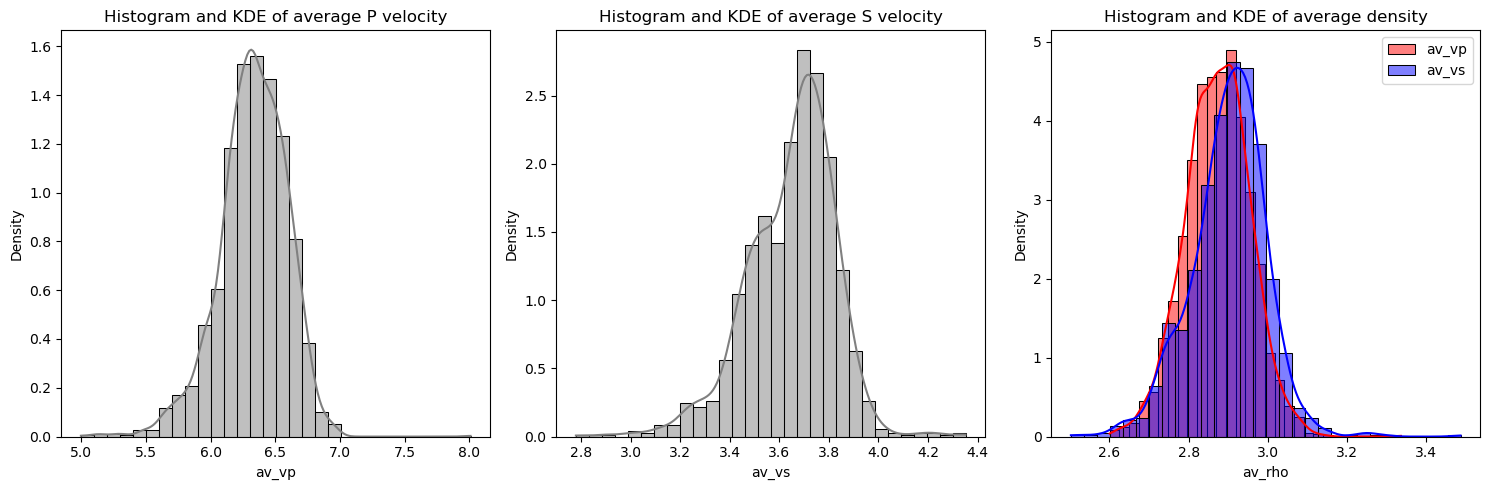

In [12]:
# Define the number of bins
num_bins = 30

# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms and KDE plots for 'av_vp' and 'av_vs'
for i, col in enumerate(['av_vp', 'av_vs']):
    sns.histplot(output_data_converted[col],
                  ax=axs[i], kde=True, color='gray', 
                  stat="density", bins=num_bins)

# Plot semi-transparent histograms and KDE plots for 'av_rho'
av_vp_not_nan = output_data_converted[
    output_data_converted['av_vp'].notna()]['av_rho']
av_vs_not_nan = output_data_converted[
    output_data_converted['av_vs'].notna()]['av_rho']

sns.histplot(av_vp_not_nan, ax=axs[2], kde=True, 
             color='red', alpha=0.5, stat="density", 
             bins=num_bins, label='av_vp')
sns.histplot(av_vs_not_nan, ax=axs[2], kde=True,
             color='blue', alpha=0.5, stat="density",
              bins=num_bins, label='av_vs')

# Add a legend to the third plot
axs[2].legend()

# Set column titles
axs[0].set_title('Histogram and KDE of average P velocity')
axs[1].set_title('Histogram and KDE of average S velocity')
axs[2].set_title('Histogram and KDE of average density')

# Display the plot
plt.tight_layout()
plt.show()

## Locating coincident profiles

Now we will locate $V_P$ and $V_S$ profiles that are within a given distance of one another to check how the density conversion performs and wether crustal thickness estimates match up etc.

First we need to divide the `station_profiles` list up into two batches, in this case of Vp and Vs profiles.  Note that we can divide the `station_profiles` list in any arbitary way to make comparisons.

Next we will run the `get_coincident_profiles` function in the `coincident_profiles` module.  Running this function will print a progress report tracking how far through the station_profiles list the program has progressed.  It will return a list of stations that are in the same location as another profile given a buffer distance `buff_dist`.  This list will be organised in the same way as `station_profiles`, but will have empty entries where there are no profiles coincident with that station.

In [13]:
buff_dist = 20 # buffer distance to nearest profile

# extract vs profiles and vp profiles from station_profiles
vs_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vs', station_profiles)))
vp_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vp', station_profiles)))

# calculate coincident vp and vs profiles within buffer distance, buff
coincident_profiles, vp_profiles, vs_profiles = cnc.get_coincident_profiles(vp_profiles, vs_profiles, buff_dist)

Finding stations with coincident Vp and Vs surveys...
   -- this may take a few minutes...!
   -- taking locations < 20.0 km from vp measurement
       - currently on item 100 of 2748
       - currently on item 200 of 2748
       - currently on item 300 of 2748
       - currently on item 400 of 2748
       - currently on item 500 of 2748
       - currently on item 600 of 2748
       - currently on item 700 of 2748
       - currently on item 800 of 2748
       - currently on item 900 of 2748
       - currently on item 1000 of 2748
       - currently on item 1100 of 2748
       - currently on item 1200 of 2748
       - currently on item 1300 of 2748
       - currently on item 1400 of 2748
       - currently on item 1500 of 2748
       - currently on item 1600 of 2748
       - currently on item 1700 of 2748
       - currently on item 1800 of 2748
       - currently on item 1900 of 2748
       - currently on item 2000 of 2748
       - currently on item 2100 of 2748
       - currently on it

We can now extract bulk properties of these profiles that are located in the same place.  For example, we can compare bulk seismic velocities and moho depth etc.

In [14]:
# get some bulk crustal properties for the coincident profiles,
#  e.g. compare densities or moho depth etc.
# also return the location of coincident profiles.
vp_vs_vpcalc, rho_rho, moho_moho, lon_lat = \
    cnc.compare_adjacent_profiles(vp_profiles, coincident_profiles, approach="stephenson")

## Output and plotting

Now we can plot up the results of locating these coincident profiles.  We will again use some functionality from the `plotting` module in `SMV2rho`.  

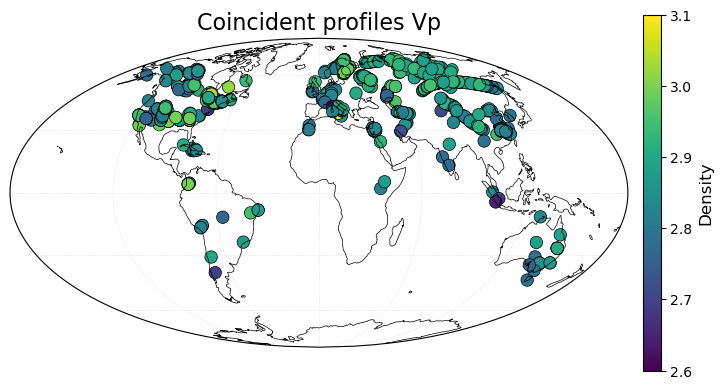

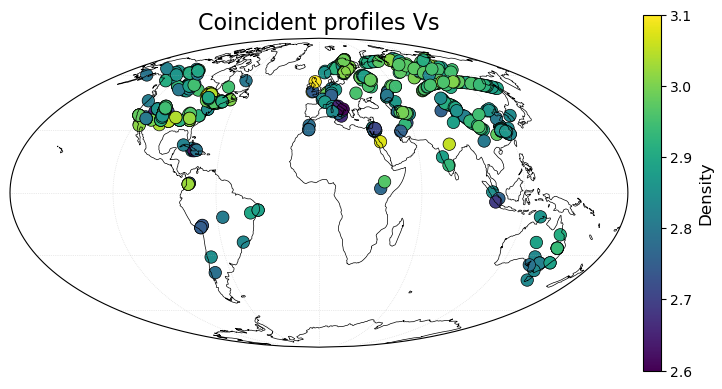

In [15]:
# Locations of coincident profiles (Vp density)
lon, lat = lon_lat[:,0], lon_lat[:,1]
color = rho_rho[:,0]

smplt.plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vp', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])

# Locations of coincident profiles (Vs density)
color = rho_rho[:,1]
smplt.plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vs', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])


We can now plot scatter crossplots of $V_P$ and aginst $V_S$, densities and moho depths.  The red lines in the plots represent the best-fitting orthogonal-distance regression line.  ODR regression assues errors are present in both $x$ and $y$ coordinates.

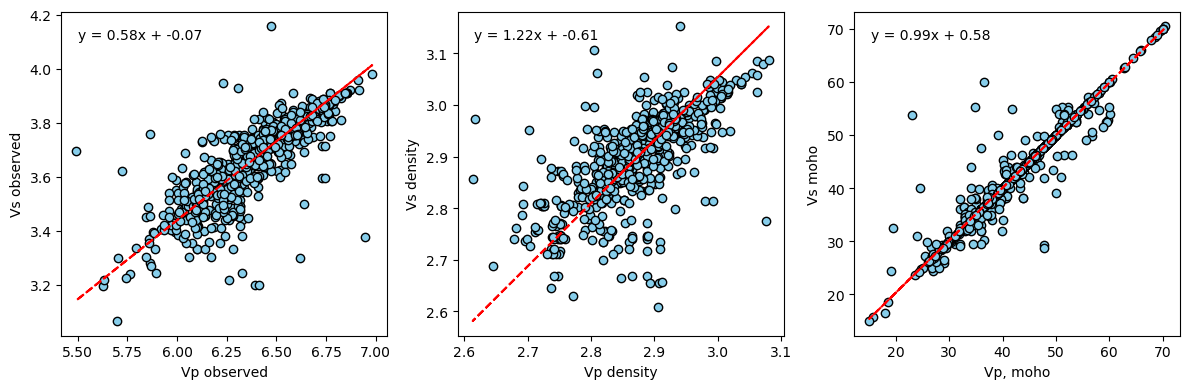

In [17]:
smplt.plot_three_scatter(vp_vs_vpcalc[:, :2], 
                   rho_rho, moho_moho, 
                   x_labels=["Vp observed", "Vp density", "Vp, moho"], 
                   y_labels=["Vs observed", "Vs density", "Vs moho"])

We can see that there is a central, positive relationship between $V_P$ and $V_S$ and the densities that we have calculated.  There is clearly significant scatter, which is likely due to variations in crustal structure over the buffer distance between profiles, the difficulties in estimating crustal structure from seismic velocities and uncertainties in the parameters and parametrisation used to convert from seismic velocity to density.  These results indicate both that this scheme is a useful approximation for calculating density from velocity profiles, but can only be as good as the (significant) uncertainties and errors in the input data and parameters!

## Clean up some obvious outliers

In [18]:
filtered_station_profiles = []

for i in station_profiles:
    if 'av_Vs' in i and 3.05 < i['av_Vs'] < 4.25:
        filtered_station_profiles.append(i)
    if 'av_Vp' in i and 5.1 < i['av_Vp'] < 7.1:
        filtered_station_profiles.append(i)

# set the filtered station profiles as the new station profiles
#  allow objects to remain linked so that if we filter again both
#  will be updated.
profiles.station_profiles = filtered_station_profiles

len(filtered_station_profiles)

4067

## Relationship between crustal thickness and bulk density 

We can now explore the relationship between crustal thickness and bulk density.  To do this, we will load in the crustal thickness database from SeisCRUST and calculate a relationship between crustal thickness and bulk density from our data.

In [19]:
all_crustal_thickness_file = "../../SEISCRUST_WORKING/CRUSTAL_THICKNESS/seisCRUST_thickness_QC.csv"

# read in the crustal thickness database
all_crustal_thickness_data = smd.read_no_profile_data(all_crustal_thickness_file)

# print some summary statistics of the crustal thickness database
all_crustal_thickness_data.describe()

,lon,lat,moho,vp_vs
count,26725.000000,26725.000000,26725.000000,17003.000000
mean,25.792699,31.095287,39.679261,1.763848
std,84.198021,23.714109,10.042792,0.076951
min,-179.335000,-82.120000,8.000000,1.130000
25%,-51.330000,25.125000,32.740974,1.720000
50%,34.830000,36.700000,38.500000,1.750000
75%,103.418000,45.020000,44.900000,1.800000
max,179.952000,82.503300,94.500000,2.601000


Next we will collate together bulk information for each profile

In [20]:
# collate bulk information for each profile
station_array = np.array([s['station'] for s in filtered_station_profiles])
lon_lat_array = np.array([ll['location'] for ll in filtered_station_profiles])
av_rho_array = np.array([r['av_rho'] for r in filtered_station_profiles])
moho_array = np.array([m['moho'] for m in filtered_station_profiles])
region_array = np.array([rgn['region'] for rgn in filtered_station_profiles])

# get arrays of average Vp and Vs
av_vp_array = [station['av_Vp'] if 'av_Vp' in station else np.nan 
               for station in filtered_station_profiles]
av_vs_array = [station['av_Vs'] if 'av_Vs' in station else np.nan 
               for station in filtered_station_profiles]

# create output dataframe of bulk information...
#   [station_name, lon, lat, crust_thickness, 
#    average_vp, average_vs, average_density]
#   if original velocity file is vp, write vs = np.nan and vice versa
#output_data = np.column_stack((station_array, lon_lat_array, moho_array, 
#                                av_vp_array, av_vs_array, av_rho_array))
output_data_converted = pd.DataFrame({'station': station_array,
                                      'lon': lon_lat_array[:,0], 
                                      'lat': lon_lat_array[:,1],
                                      'moho': moho_array, 
                                      'av_vp': av_vp_array,
                                      'av_vs': av_vs_array, 
                                      'av_rho': av_rho_array,
                                      'region': region_array})

# print sumamry statistics for the velocity profile dataframe
output_data_converted.describe()

,lon,lat,moho,av_vp,av_vs,av_rho
count,4067.000000,4067.000000,4067.000000,2745.000000,1322.000000,4067.000000
mean,8.057091,34.929147,39.702756,6.329190,3.650229,2.882172
std,80.125933,27.863355,9.036782,0.257949,0.167177,0.085432
min,-168.970000,-67.300000,15.000000,5.131414,3.062088,2.594869
25%,-71.639000,28.545000,34.000000,6.179599,3.539132,2.825864
50%,25.400000,41.160000,39.500000,6.339900,3.676490,2.885822
75%,72.355000,53.460000,44.600000,6.513255,3.767625,2.940060
max,175.230000,80.170000,77.000000,6.982412,4.229862,3.262355


Next we will generate an average and bulk velocity profile and bulk density profile using the `av_profile` function in the density_functions module.

This function reads in a family of profiles and calculates the average property as a function of depth.  For example, it can calculate average $V_P$ as a function of depth.  We will calculate average $V_P$, $V_S$ and $\rho$.  The function will also average the average profile to yield a bulk crustal property as a function of crustal thickness.  For example, we can calculate average $V_P$ as a function of crustal thickness etc.  This will allow us to make a prediction of bulk crustal velocity and density as a function of crustal thickness alone.  We can set `bulk_depth_limit` if we want to limit the maximum crustal thickness up to which we calculate the bulk property curves.

In [21]:
# maximum depth down to which bulk crustal properties will be calculated
# ie. average and bulk vp, va, rho
bulk_depth_limit = 70

# averaging approach (i.e. mean or median)
#average_type = "median"
average_type = "mean"

# get average density as function of depth and bulk density as function 
# of crustal thickness
print("Getting average density, Vp and Vs profiles")
rho_z, rho_tc = smd.av_profile([profile['rho_hi_res'] 
                             for profile in filtered_station_profiles], 
                             bulk_depth_limit,
                             average_type = average_type)
Vp_z, Vp_tc = smd.av_profile([profile['Vp_hi_res'] 
                          for profile in filtered_station_profiles 
                          if 'Vp' in profile], 
                          bulk_depth_limit, average_type = average_type)
Vs_z, Vs_tc = smd.av_profile([profile['Vs_hi_res'] 
                          for profile in filtered_station_profiles 
                          if 'Vs' in profile], 
                          bulk_depth_limit, average_type = average_type)

# calculate bulk density from bulk crustal thickness for places without V profiles
# write nan if the density is outside the depth limit 
# (I.e. on really thick crust where bulk profile is unreliable)
all_crustal_thickness_data['av_rho'] = np.where(
                                all_crustal_thickness_data['moho'] < bulk_depth_limit, 
                                rho_tc(all_crustal_thickness_data['moho']), np.nan)

# merge dataframes to create single output file (how='outer' to preserve all keys)
output_data_all = pd.merge(output_data_converted, 
                           all_crustal_thickness_data, how='outer')

Getting average density, Vp and Vs profiles


We have now generated a database of crustal thickness data, bulk seismic velocity and bulk density.  Note that we have duplicated the locations where we have velocity profiles by calculating bulk density directly from the profiles, but then also from the bulk density approximation.

Now print the coefficients for he polynomial functions that best-fit the empirical relationship calculated above.

In [22]:
# average density as a function of depth
print(np.polyfit(np.linspace(0, 50, 100), rho_z(np.linspace(0, 50, 100)), 3))

# density as a function of crustal thickness
print(np.polyfit(np.linspace(0, 50, 100), rho_tc(np.linspace(0, 50, 100)), 3))


[-9.82446937e-06  7.26695464e-04 -4.87188726e-03  2.75166360e+00]
[-2.54922102e-06  2.50333382e-04 -2.64394998e-03  2.75316978e+00]


### Data Exploration

We can now explore our whole database.  First we will print the key statistics of the database.

next, we will plot up all density information on a map showing those locations with velocity profiles and those locations without that are absed upon bulk density as a function of crustal thickness.

In [23]:
output_data_all.describe()

,lon,lat,moho,av_vp,av_vs,av_rho,vp_vs
count,30792.000000,30792.000000,30792.000000,2745.000000,1322.000000,30467.000000,17003.000000
mean,23.450184,31.601662,39.682364,6.329190,3.650229,2.876431,1.763848
std,83.885487,24.336922,9.915636,0.257949,0.167177,0.049529,0.076951
min,-179.335000,-82.120000,8.000000,5.131414,3.062088,2.594869,1.130000
25%,-61.632250,25.320000,32.979000,6.179599,3.539132,2.842766,1.720000
50%,33.331000,37.180000,38.600000,6.339900,3.676490,2.875885,1.750000
75%,102.800000,45.990000,44.900000,6.513255,3.767625,2.909702,1.800000
max,179.952000,82.503300,94.500000,6.982412,4.229862,3.262355,2.601000


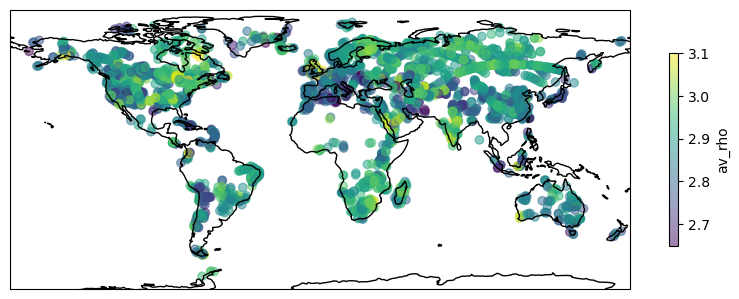

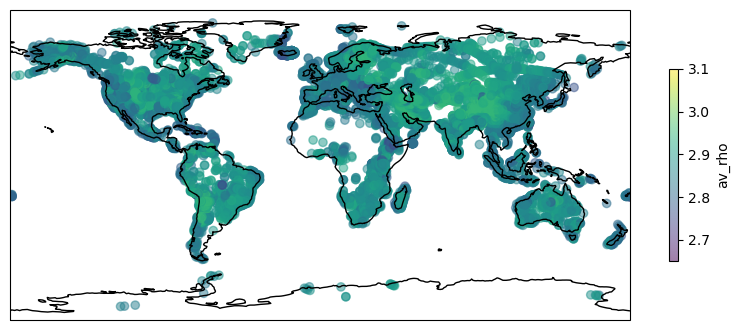

In [24]:
# Define color scale limits
vmin = 2.65
vmax = 3.1

# Create a map for places where the station field is not NaN
fig1 = plt.figure(figsize=(10, 5))
ax1 = fig1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax1.coastlines()

# Filter data where station is not NaN
data_not_nan = output_data_all[output_data_all['station'].notna()]

# Plot 'av_rho' field with color mapping
sc1 = ax1.scatter(data_not_nan['lon'], data_not_nan['lat'], c=data_not_nan['av_rho'], 
                  alpha=0.5, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(sc1, label='av_rho', shrink=0.5, pad=0.05, ax=ax1)

plt.show()

# Create a map for places where the station field is NaN
fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2.coastlines()

# Filter data where station is NaN
data_nan = output_data_all[output_data_all['station'].isna()]

# Plot 'av_rho' field with color mapping
sc2 = ax2.scatter(data_nan['lon'], data_nan['lat'], c=data_nan['av_rho'], 
                  alpha=0.5, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(sc2, label='av_rho', shrink=0.5, pad=0.05, ax=ax2)

plt.show()

Now we can use `seaborn` to plot a scatter pairplot of all parameters against one another in order to explore the relationships between the aprameters.  This script may spit out a `FutureWarning` that can be safely ignored.  This warning is caused the backend of `seaborn`.

/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/eart0518/opt/anaconda3/envs/density/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Figure size 1000x1000 with 0 Axes>

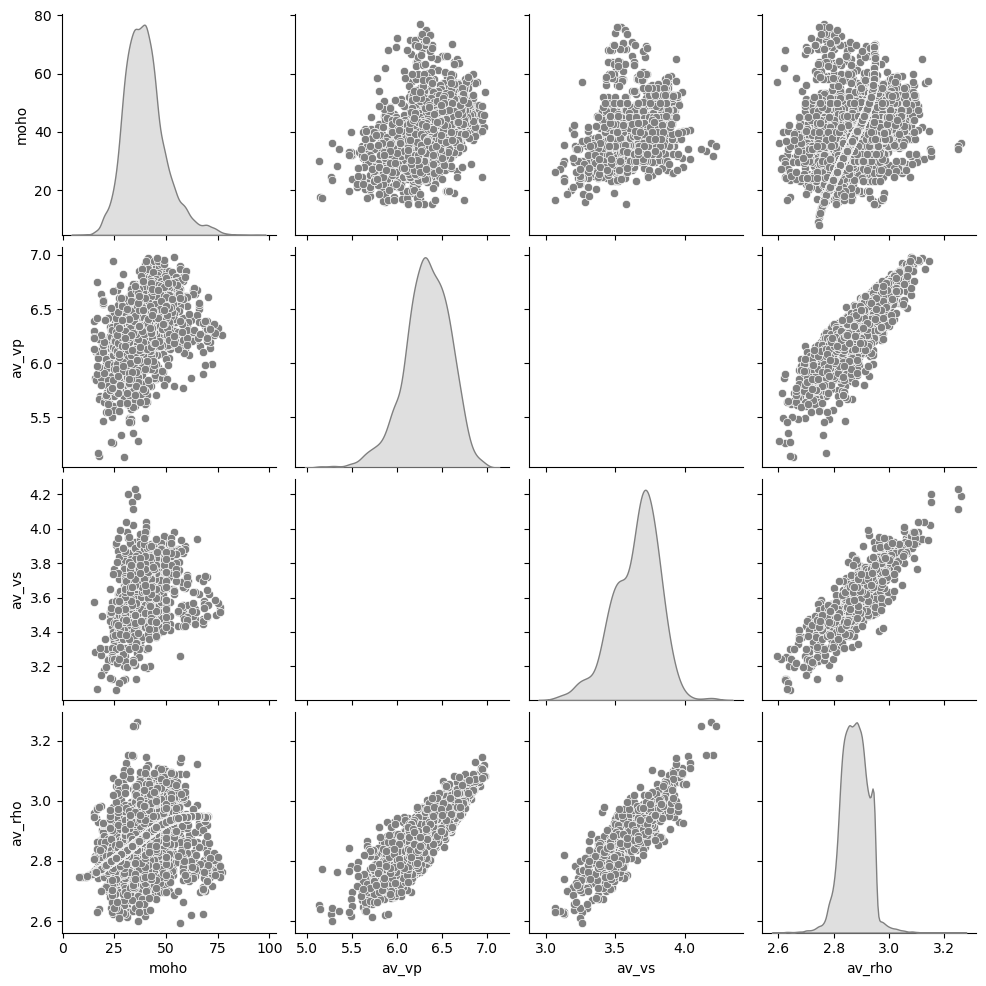

In [25]:
# Set the figure size
plt.figure(figsize=(10, 10))

# Create the pairplot with KDE plots on the diagonal
sns.pairplot(output_data_all[['moho', 'av_vp', 'av_vs', 'av_rho']], 
             plot_kws={'color': 'grey'}, 
             diag_kws={'color': 'grey'}, 
             diag_kind='kde')

# Show the plot
plt.show()

## Write final data tables

Finally, we can write out some of the data calculated and explored in this tutorial.  There are not bespoke functions to write a lot of these data because exactly what each user wants from their data may vary substantially!  The code below might give a little bit of an indication as to the sorts of things you may want to write.

In [33]:
# WRITE OUTPUT DATA FILES

outpath = "../../SEISCRUST/BULK_CRUSTAL_PROPERTIES/"

# file containing all moho depth, bulk crustal thickness and velocity estimates
av_vp_vs_rho_file = "av_vp_vs_rho_all"

# empirical average density as function of depth function
average_rho_z_file = "av_dens_depth_function_T_DEPENDENT.dat"
average_vp_z_file = "av_vp_depth_function_T_DEPENDENT.dat"
average_vs_z_file = "av_vs_depth_function_T_DEPENDENT.dat"

# empirial bulk density as function of crustal thickness function
bulk_rho_tc_file = "bulk_rho_tc_function_T_DEPENDENT.dat"
bulk_vp_tc_file = "bulk_vp_tc_function_T_DEPENDENT.dat"
bulk_vs_tc_file = "bulk_vs_tc_function_T_DEPENDENT.dat"

# check approach and whether T dependence is being used for outfile path names
if approach == 'stephenson':
    if profiles.T_dependence is True:
        print("Saving T dependent bulk density file...")
        approach = approach + "_T_DEPENDENT"
        outfile = outpath + av_vp_vs_rho_file + "_" + approach + ".dat"
    else:
        print("Saving T bulk density file...")
        outfile = outpath + av_vp_vs_rho_file + "_" + approach + ".dat"

# save global average velocity and density
print("Saving concatenated, high-resolution velocity and density files...")
np.savetxt(outpath + "density_high_res_global" + "_" + approach + ".dat", 
            np.concatenate([profile['rho_hi_res'] 
                            for profile in station_profiles]))
np.savetxt(outpath + "Vp_high_res_global.dat", 
            np.concatenate([profile['Vp_hi_res'] 
                            for profile in station_profiles if
                            'Vp_hi_res' in profile]))
np.savetxt(outpath + "Vs_high_res_global.dat", 
            np.concatenate([profile['Vs_hi_res'] 
                            for profile in station_profiles if
                            'Vs_hi_res' in profile]))

# save average density, Vp and Vs as function of depth and bulk density as function
#   of crustal thickness.  Ensure NaNs appear as 'nan' and separator is space.
print("Saving bulk density data file...")
output_data_all.to_csv(outfile, sep=' ', index=False, na_rep='nan',
                        columns=['station', 'lon', 'lat', 'moho', 
                                'av_vp', 'av_vs', 'av_rho'])

smd.save_bulk_profiles(outpath, average_rho_z_file, rho_z, 0, 50, 0.5)
smd.save_bulk_profiles(outpath, bulk_rho_tc_file, rho_tc, 0, 50, 0.5)
smd.save_bulk_profiles(outpath, average_vp_z_file, Vp_z, 0, 50, 0.5)
smd.save_bulk_profiles(outpath, bulk_vp_tc_file, Vp_tc, 0, 50, 0.5)
smd.save_bulk_profiles(outpath, average_vs_z_file, Vs_z, 0, 50, 0.5)
smd.save_bulk_profiles(outpath, bulk_vs_tc_file, Vs_tc, 0, 50, 0.5)

Saving T dependent bulk density file...
Saving concatenated, high-resolution velocity and density files...
Saving bulk density data file...
